In [1]:
"""
Usage example employing Lasagne for digit recognition using the MNIST dataset.
This example is deliberately structured as a long flat file, focusing on how
to use Lasagne, instead of focusing on writing maximally modular and reusable
code. It is used as the foundation for the introductory Lasagne tutorial:
http://lasagne.readthedocs.org/en/latest/user/tutorial.html
More in-depth examples and reproductions of paper results are maintained in
a separate repository: https://github.com/Lasagne/Recipes
"""

from __future__ import print_function

import sys
import os
import time

import numpy as np
import theano
from theano import pp, printing
import theano.tensor as T

import lasagne

import matplotlib.pyplot as plt

In [2]:
# ################## Download and prepare the MNIST dataset ##################
# This is just some way of getting the MNIST dataset from an online location
# and loading it into numpy arrays. It doesn't involve Lasagne at all.

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test


# ##################### Build the neural network model #######################
# This script supports three types of models. For each one, we define a
# function that takes a Theano variable representing the input and returns
# the output layer of a neural network model built in Lasagne.

def build_mlp(input_var=None):
    # This creates an MLP of two hidden layers of 800 units each, followed by
    # a softmax output layer of 10 units. It applies 20% dropout to the input
    # data and 50% dropout to the hidden layers.

    # Input layer, specifying the expected input shape of the network
    # (unspecified batchsize, 1 channel, 28 rows and 28 columns) and
    # linking it to the given Theano variable `input_var`, if any:
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                     input_var=input_var)

    # Apply 20% dropout to the input data:
    l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)

    # Add a fully-connected layer of 800 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    # We'll now add dropout of 50%:
    #l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=0.5)

    # Another 800-unit layer:
    #l_hid2 = lasagne.layers.DenseLayer(
    #        l_hid1_drop, num_units=800,
    #        nonlinearity=lasagne.nonlinearities.rectify)

    # 50% dropout again:
    #l_hid2_drop = lasagne.layers.DropoutLayer(l_hid2, p=0.5)

    # Finally, we'll add the fully-connected output layer, of 10 softmax units:
    l_out = lasagne.layers.DenseLayer(
            l_hid1, num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    # Each layer is linked to its incoming layer(s), so we only need to pass
    # the output layer to give access to a network in Lasagne:
    return l_out


def build_custom_mlp(input_var=None, depth=2, width=800, drop_input=.2,
                     drop_hidden=.5):
    # By default, this creates the same network as `build_mlp`, but it can be
    # customized with respect to the number and size of hidden layers. This
    # mostly showcases how creating a network in Python code can be a lot more
    # flexible than a configuration file. Note that to make the code easier,
    # all the layers are just called `network` -- there is no need to give them
    # different names if all we return is the last one we created anyway; we
    # just used different names above for clarity.

    # Input layer and dropout (with shortcut `dropout` for `DropoutLayer`):
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    if drop_input:
        network = lasagne.layers.dropout(network, p=drop_input)
    # Hidden layers and dropout:
    nonlin = lasagne.nonlinearities.rectify
    for _ in range(depth):
        network = lasagne.layers.DenseLayer(
                network, width, nonlinearity=nonlin)
        if drop_hidden:
            network = lasagne.layers.dropout(network, p=drop_hidden)
    # Output layer:
    softmax = lasagne.nonlinearities.softmax
    network = lasagne.layers.DenseLayer(network, 10, nonlinearity=softmax)
    return network


def build_cnn(input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network


# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.
# Notice that this function returns only mini-batches of size `batchsize`.
# If the size of the data is not a multiple of `batchsize`, it will not
# return the last (remaining) mini-batch.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [3]:
# ############################## Main program ################################
# Everything else will be handled in our main program now. We could pull out
# more functions to better separate the code, but it wouldn't make it any
# easier to read.

def main(model='mlp', num_epochs=500):
    # Load the dataset
    print("Loading data...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    if model == 'mlp':
        network = build_mlp(input_var)
    elif model.startswith('custom_mlp:'):
        depth, width, drop_in, drop_hid = model.split(':', 1)[1].split(',')
        network = build_custom_mlp(input_var, int(depth), int(width),
                                   float(drop_in), float(drop_hid))
    elif model == 'cnn':
        network = build_cnn(input_var)
    else:
        print("Unrecognized model type %r." % model)
        return

    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))



    # Optionally, you could now dump the network weights to a file like this:
    # np.savez('model.npz', *lasagne.layers.get_all_param_values(network))
    #
    # And load them again later on like this:
    # with np.load('model.npz') as f:
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    # lasagne.layers.set_all_param_values(network, param_values)


if __name__ == '__main__':
    if ('--help' in sys.argv) or ('-h' in sys.argv):
        print("Trains a neural network on MNIST using Lasagne.")
        print("Usage: %s [MODEL [EPOCHS]]" % sys.argv[0])
        print()
        print("MODEL: 'mlp' for a simple Multi-Layer Perceptron (MLP),")
        print("       'custom_mlp:DEPTH,WIDTH,DROP_IN,DROP_HID' for an MLP")
        print("       with DEPTH hidden layers of WIDTH units, DROP_IN")
        print("       input dropout and DROP_HID hidden dropout,")
        print("       'cnn' for a simple Convolutional Neural Network (CNN).")
        print("EPOCHS: number of training epochs to perform (default: 500)")
    else:
        kwargs = {}
        #print (str(sys.argv))
        #if len(sys.argv) > 1:
        #    kwargs['model'] = sys.argv[1]
        #if len(sys.argv) > 2:
        #    kwargs['num_epochs'] = int(sys.argv[2])
main('mlp', 2)

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 10 took 6.301s
  training loss:		0.908627
  validation loss:		0.398168
  validation accuracy:		89.64 %
Epoch 2 of 10 took 6.946s
  training loss:		0.430776
  validation loss:		0.322637
  validation accuracy:		91.21 %
Epoch 3 of 10 took 8.231s
  training loss:		0.372223
  validation loss:		0.290894
  validation accuracy:		91.86 %
Epoch 4 of 10 took 7.801s
  training loss:		0.341401
  validation loss:		0.267018
  validation accuracy:		92.58 %
Epoch 5 of 10 took 7.664s
  training loss:		0.319395
  validation loss:		0.250520
  validation accuracy:		93.08 %
Epoch 6 of 10 took 6.967s
  training loss:		0.302520
  validation loss:		0.236531
  validation accuracy:		93.29 %
Epoch 7 of 10 took 6.825s
  training loss:		0.284693
  validation loss:		0.225285
  validation accuracy:		93.69 %
Epoch 8 of 10 took 6.690s
  training loss:		0.271732
  validation loss:		0.213707
  validation accuracy:		94.15 %
Epoch 9 o

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [5]:
#printing.debugprint(lasagne.utils.one_hot([1,2,3], m=None))
#lasagne.layers.get_output(lasagne.utils.one_hot([1,2,3], m=15), deterministic=True)
num_inp = 1000
t = np.zeros((num_inp,1,1,15))
for i in range(num_inp):
    t[i,0,0,np.random.randint(0,15)] = 1
    
y_train.shape

(50000,)

## Network Analysis Helper Code

In [14]:
def compile_saliency_function(net,inpu):
    """
    Compiles a function to compute the saliency maps and predicted classes
    for a given minibatch of input images.
    """
    inp = inpu
    outp = lasagne.layers.get_output(net, deterministic=True)
    max_outp = T.max(outp, axis=1)
    saliency = theano.grad(max_outp.sum(), wrt=inp)
    max_class = T.argmax(outp, axis=1)
    return theano.function([inp], [saliency, max_class])



def show_images(img_original, saliency, max_class, title):
    # get out the first map and class from the mini-batch
    #saliency = saliency[0]
    #max_class = max_class[0]
    # convert saliency from BGR to RGB, and from c01 to 01c
    #saliency = saliency[::-1].transpose(1, 2, 0)
    # plot the original image and the three saliency map variants
    plt.figure(figsize=(1, 15), facecolor='w')
    #plt.suptitle("Class: " + max_class + ". Saliency: " + title)
    plt.subplot(2, 2, 1)
    plt.title('input')
    plt.imshow(img_original)
    plt.subplot(2, 2, 2)
    plt.title('abs. saliency')
    plt.imshow(np.abs(saliency), cmap='gray')
    plt.subplot(2, 2, 3)
    plt.title('pos. saliency')
    plt.imshow((np.maximum(0, saliency) / saliency.max()))
    plt.subplot(2, 2, 4)
    plt.title('neg. saliency')
    plt.imshow((np.maximum(0, -saliency) / -saliency.min()))
    plt.show()
    
def _blob(x, y, area, colour):
    """
    Draws a square-shaped blob with the given area (< 1) at
    the given coordinates.
    """
    hs = np.sqrt(area) / 2
    xcorners = np.array([x - hs, x + hs, x + hs, x - hs])
    ycorners = np.array([y - hs, y - hs, y + hs, y + hs])
    plt.fill(xcorners, ycorners, colour, edgecolor=colour)

def hinton(W, names=None, maxweight=None, filename=None):
# def hinton(W, maxweight=None):
    """
    Draws a Hinton diagram for visualizing a weight matrix. 
    Temporarily disables matplotlib interactive mode if it is on, 
    otherwise this takes forever.
    """


    # F = plt.gcf()
    # F.set_dpi( 300 )
    # print "DPI", F.get_dpi()

    F = plt.figure(num=None, figsize=(8,6), dpi=300, facecolor='w', edgecolor='k')

    reenable = False
    if plt.isinteractive():
        plt.ioff()
    
    F.clf()
    height, width = W.shape
    if not maxweight:
        maxweight = 2**np.ceil(np.log(np.max(np.abs(W)))/np.log(2))
        print ("Max weight: "  + str(maxweight))
        
    plt.fill(np.array([0, width, width, 0]),
             np.array([0, 0, height, height]),
             'gray')
    
    plt.axis('off')
    plt.axis('equal')
    for x in xrange(width):
        if names:
            plt.text(-0.5, x, names[x], fontsize=4, ha='right', va='bottom')
            plt.text(x, height+0.5, names[height-x-1], fontsize=4, va='bottom', rotation='vertical', ha='left')
        for y in xrange(height):
            _x = x+1
            _y = y+1
            w = W[y, x]
            if w > 0:
                _blob(_x - 0.5,
                      height - _y + 0.5,
                      min(1, w/maxweight),
                      'white')
            elif w < 0:
                _blob(_x - 0.5,
                      height - _y + 0.5, 
                      min(1, -w/maxweight), 
                      'black')
    if reenable:
        plt.ion()

    if filename:
        F.savefig(filename, dpi=300)
        #print >>sys.stderr, "Wrote:", filename

Data and Neural Network Definitions
===================================================


In [35]:
def load_dataset(num_inp=10000, num_test=2000, num_categories=15, timesteps_per_stim=4):
    num_inp = 1000
    X_train = np.zeros((num_inp*timesteps_per_stim,1,1,num_categories))
    y_train = np.zeros((num_inp*timesteps_per_stim))
    
    for i in range(num_inp):
        r = np.random.randint(0,num_categories)
        for j in range(timesteps_per_stim):
            X_train[i*timesteps_per_stim+j,0,0,r] = 1
            y_train[i*timesteps_per_stim+j] = (1.0/(num_categories-1))*r
    
    # We reserve the last training examples for validation.
    X_train, X_val = X_train[:-(num_inp/10)], X_train[-(num_inp/10):]
    y_train, y_val = y_train[:-(num_inp/10)], y_train[-(num_inp/10):]
    
    
    X_test = np.zeros((num_test*timesteps_per_stim,1,1,num_categories))
    y_test = np.zeros((num_test*timesteps_per_stim))
    for i in range(num_test):
        r = np.random.randint(0,num_categories)
        for j in range(timesteps_per_stim):
            X_test[i*timesteps_per_stim+j,0,0,r] = 1
            y_test[i*timesteps_per_stim+j] = (1.0/(num_categories-1))*r
        
    return X_train, y_train, X_val, y_val, X_test, y_test

def feed_forward(input_var, num_categories, dropout=False, num_hid=100):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 1, num_categories), input_var=input_var)
    
    if (dropout):
        l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)
    
        l_hid1 = lasagne.layers.DenseLayer(
                l_in_drop, num_units=num_hid,
                nonlinearity=lasagne.nonlinearities.rectify,
                W=lasagne.init.GlorotUniform())
    else:
        l_hid1 = lasagne.layers.DenseLayer(
                l_in, num_units=num_hid,
                nonlinearity=lasagne.nonlinearities.rectify,
                W=lasagne.init.GlorotUniform())
    
    l_out = lasagne.layers.DenseLayer(
            l_hid1, num_units=1,
            nonlinearity=lasagne.nonlinearities.sigmoid)
    
    return l_out
    
def recursive(rec_input_var, num_categories, gru=True):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 1, num_categories), input_var=rec_input_var)
    
    #l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)
    
    if (gru):
        l_rec = lasagne.layers.GRULayer(l_in, num_units=100)
    else:
        l_rec = lasagne.layers.LSTMLayer(l_in, num_units=100)

    l_shp = lasagne.layers.ReshapeLayer(l_rec, (-1, 100))
    
    l_hid1 = lasagne.layers.DenseLayer(
            l_shp, num_units=100,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    
    
    l_out = lasagne.layers.DenseLayer(
            l_hid1, num_units=1,
            nonlinearity=lasagne.nonlinearities.sigmoid)
    
    return l_out

def in_out(input_var, num_categories, recursive_layer=False):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 1, num_categories), input_var=input_var)
    
    if (not recursive_layer):
        l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)
        
        l_hid1 = lasagne.layers.DenseLayer(
                l_in_drop, num_units=100,
                nonlinearity=lasagne.nonlinearities.rectify,
                W=lasagne.init.GlorotUniform())
    
    else:
        l_lstm = lasagne.layers.LSTMLayer(l_in, num_units=100)

        l_shp = lasagne.layers.ReshapeLayer(l_lstm, (-1, 100))
    
        l_hid1 = lasagne.layers.DenseLayer(
                l_shp, num_units=100,
                nonlinearity=lasagne.nonlinearities.rectify,
                W=lasagne.init.GlorotUniform())
        
    l_flat_in = lasagne.layers.FlattenLayer(l_in, outdim=1)
    l_flat_h = lasagne.layers.FlattenLayer(l_hid1, outdim=1)
    
    l_merge = lasagne.layers.ConcatLayer((l_flat_in, l_flat_h), axis=0)
    
    l_out = lasagne.layers.DenseLayer(
            l_merge, num_units=1,
            nonlinearity=lasagne.nonlinearities.sigmoid)
    
    return l_out

# Running the Nets

In [56]:
def train_rec(print_epoch=False, num_inp=10000, num_test=2000, num_categories=15, timesteps_per_stim=4, num_epochs=100):
    num_categories = 15
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(num_categories=15, timesteps_per_stim=timesteps_per_stim)

    rec_input_var = T.tensor4('inputs')
    rec_target_var = T.dvector('targets')

    rec_network = recursive(rec_input_var, num_categories)

    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    rec_prediction = lasagne.layers.get_output(rec_network)
    rec_loss = lasagne.objectives.squared_error(rec_prediction, rec_target_var)
    rec_loss = rec_loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    rec_params = lasagne.layers.get_all_params(rec_network, trainable=True)
    rec_updates = lasagne.updates.nesterov_momentum(
        rec_loss, rec_params, learning_rate=0.01, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    rec_test_prediction = lasagne.layers.get_output(rec_network, deterministic=True)
    rec_test_loss = lasagne.objectives.squared_error(rec_test_prediction,
                                                                rec_target_var)
    rec_test_loss = rec_test_loss.mean()

    # As a bonus, also create an expression for the classification accuracy:
    #test_acc = T.mean((test_prediction - target_var),dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    rec_train_fn = theano.function([rec_input_var, rec_target_var], rec_loss, updates=rec_updates)

    # Compile a second function computing the validation loss and accuracy:
    rec_val_fn = theano.function([rec_input_var, rec_target_var], rec_test_loss)

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    num_epochs = 100
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 30, shuffle=True):
            inputs, targets = batch
            train_err += rec_train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 30, shuffle=False):
            inputs, targets = batch
            err = rec_val_fn(inputs, targets)
            val_err += err
            val_batches += 1
            #val_acc += acc

        if (print_epoch):
            # Then we print the results for this epoch:
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time))
            print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
            print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
            #print("  validation accuracy:\t\t{:.2f} %".format(
            #    val_acc / val_batches * 100))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 30, shuffle=False):
        inputs, targets = batch
        err = rec_val_fn(inputs, targets)
        test_err += err
        test_batches += 1
        #test_acc += acc
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    #print("  test accuracy:\t\t{:.2f} %".format(
    #    test_acc / test_batches * 100))
    
    return rec_network

In [57]:
def train_ff(print_epoch=False, num_inp=10000, num_test=2000, num_categories=15, timesteps_per_stim=4, num_epochs=100):
    num_categories = 15
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(num_categories=15, timesteps_per_stim=timesteps_per_stim)

    ff_input_var = T.tensor4('inputs')
    ff_target_var = T.dvector('targets')

    ff_network = feed_forward(ff_input_var, num_categories)

    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    ff_prediction = lasagne.layers.get_output(ff_network)
    ff_loss = lasagne.objectives.squared_error(ff_prediction, ff_target_var)
    ff_loss = ff_loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    ff_params = lasagne.layers.get_all_params(ff_network, trainable=True)
    ff_updates = lasagne.updates.nesterov_momentum(
        ff_loss, ff_params, learning_rate=0.01, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    ff_test_prediction = lasagne.layers.get_output(ff_network, deterministic=True)
    ff_test_loss = lasagne.objectives.squared_error(ff_test_prediction,
                                                                ff_target_var)
    ff_test_loss = ff_test_loss.mean()

    # As a bonus, also create an expression for the classification accuracy:
    #test_acc = T.mean((test_prediction - target_var),dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    ff_train_fn = theano.function([ff_input_var, ff_target_var], ff_loss, updates=ff_updates)

    # Compile a second function computing the validation loss and accuracy:
    ff_val_fn = theano.function([ff_input_var, ff_target_var], ff_test_loss)

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 30, shuffle=True):
            inputs, targets = batch
            train_err += ff_train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 30, shuffle=False):
            inputs, targets = batch
            err = ff_val_fn(inputs, targets)
            val_err += err
            val_batches += 1
            #val_acc += acc

        # Then we print the results for this epoch:
        if print_epoch:
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time))
            print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
            print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
            #print("  validation accuracy:\t\t{:.2f} %".format(
            #    val_acc / val_batches * 100))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 30, shuffle=False):
        inputs, targets = batch
        err = ff_val_fn(inputs, targets)
        test_err += err
        test_batches += 1
        #test_acc += acc
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    #print("  test accuracy:\t\t{:.2f} %".format(
    #    test_acc / test_batches * 100))
    return ff_network


'''
saliency_fn = compile_saliency_function(ff_network, ff_input_var)
saliency, max_class = saliency_fn(X_train[1].reshape(1,1,1,15))
#plt.subplot(2, 2, 1)
#plt.imshow(X_train[1].reshape(15,1))
#plt.subplot(2, 2, 2)
#plt.imshow(saliency.reshape(15,1))
#print ('saliency shape: ' + str(saliency.shape))
show_images(X_train[1].reshape(15,1), saliency.reshape(15,1), max_class, "guided backprop")
#hinton(l)
plt.show()
'''

'\nsaliency_fn = compile_saliency_function(ff_network, ff_input_var)\nsaliency, max_class = saliency_fn(X_train[1].reshape(1,1,1,15))\n#plt.subplot(2, 2, 1)\n#plt.imshow(X_train[1].reshape(15,1))\n#plt.subplot(2, 2, 2)\n#plt.imshow(saliency.reshape(15,1))\n#print (\'saliency shape: \' + str(saliency.shape))\nshow_images(X_train[1].reshape(15,1), saliency.reshape(15,1), max_class, "guided backprop")\n#hinton(l)\nplt.show()\n'

In [ ]:
num_categories = 15
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(num_categories=15)

input_var = T.tensor4('inputs')
target_var = T.dvector('targets')

network = in_out(input_var, num_categories)

# Create a loss expression for training, i.e., a scalar objective we want
# to minimize (for our multi-class problem, it is the cross-entropy loss):
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.squared_error(prediction, target_var)
loss = loss.mean()
# We could add some weight decay as well here, see lasagne.regularization.

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
    loss, params, learning_rate=0.01, momentum=0.9)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.squared_error(test_prediction,
                                                            target_var)
test_loss = test_loss.mean()

# As a bonus, also create an expression for the classification accuracy:
#test_acc = T.mean((test_prediction - target_var),dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], loss, updates=updates)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], test_loss)

# Finally, launch the training loop.
print("Starting training...")
# We iterate over epochs:
num_epochs = 150
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 30, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, 30, shuffle=False):
        inputs, targets = batch
        err = val_fn(inputs, targets)
        val_err += err
        val_batches += 1
        #val_acc += acc

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    #print("  validation accuracy:\t\t{:.2f} %".format(
    #    val_acc / val_batches * 100))

# After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 30, shuffle=False):
    inputs, targets = batch
    err = val_fn(inputs, targets)
    test_err += err
    test_batches += 1
    #test_acc += acc
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
#print("  test accuracy:\t\t{:.2f} %".format(
#    test_acc / test_batches * 100))

# Evaluating the Models

(15, 100)
(100,)
(100, 1)
(1,)
Max weight: 1.0
Max weight: 1.0


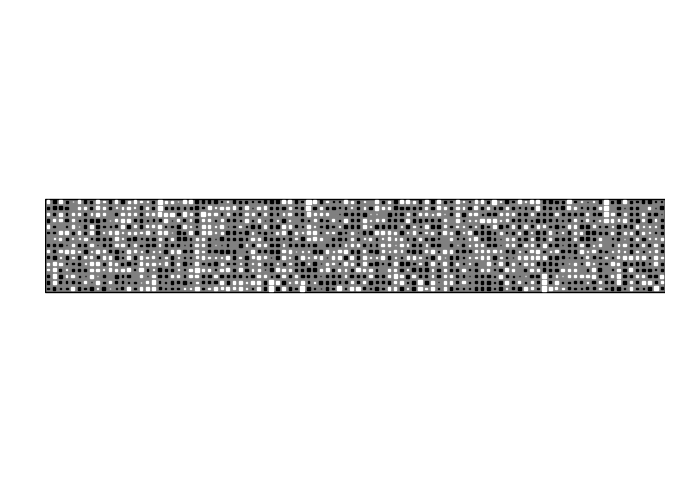

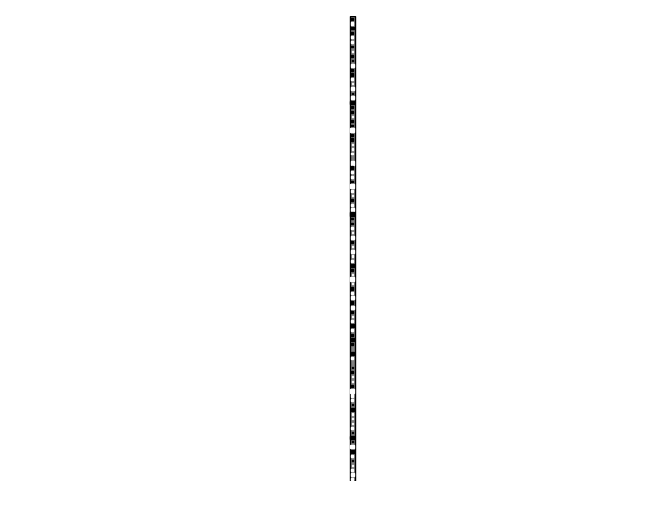

In [16]:
for i in lasagne.layers.get_all_param_values(ff_network):
    print (i.shape)
    
W = lasagne.layers.get_all_param_values(ff_network)
hinton(W[0])
hinton(W[2])
plt.show()

In [62]:
per_stim = 5
epochs = 10
ff_network = train_ff(timesteps_per_stim=per_stim, num_epochs=epochs)
rec_network = train_rec(timesteps_per_stim=per_stim, num_epochs=epochs)

Starting training...
Final results:
  test loss:			0.000597
Starting training...
Final results:
  test loss:			0.000025


[[ 0.06565611]
 [ 0.09603352]
 [ 0.1479801 ]
 [ 0.2084768 ]
 [ 0.28515183]
 [ 0.35459191]
 [ 0.4272442 ]
 [ 0.50091357]
 [ 0.57243417]
 [ 0.64394368]
 [ 0.71692228]
 [ 0.78799108]
 [ 0.85685399]
 [ 0.90600397]
 [ 0.93729448]]
[[ 0.01292153]
 [ 0.07056681]
 [ 0.14261756]
 [ 0.21418342]
 [ 0.28566907]
 [ 0.35707752]
 [ 0.42854105]
 [ 0.50002375]
 [ 0.57144942]
 [ 0.64294079]
 [ 0.71436133]
 [ 0.78582629]
 [ 0.85736775]
 [ 0.92930611]
 [ 0.9857071 ]]


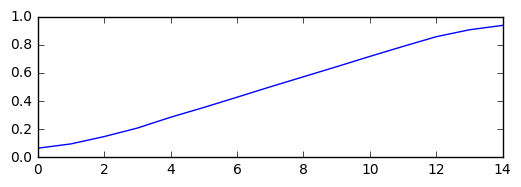

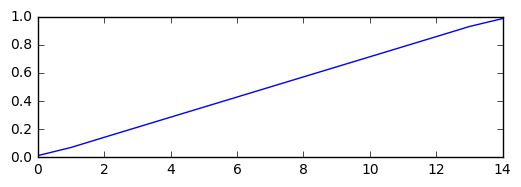

In [63]:
X_testo = np.zeros((15,1,1,15))
y_testo = np.zeros((15))
for i in range(15):
        r = 15
        X_testo[i,0,0,i] = 1
        y_testo[i] = (1.0/(num_categories-1))*i


input_theano_var = T.tensor4('inputs')
ff_pred = lasagne.layers.get_output(ff_network, input_theano_var)
get_ff_pred = theano.function([input_theano_var], ff_pred)
#print(X_train[1].reshape((1,1,1,15)))
print(get_ff_pred(X_testo))

r_input_theano_var = T.tensor4('inputs')
r_pred = lasagne.layers.get_output(rec_network, r_input_theano_var)
get_r_pred = theano.function([r_input_theano_var], r_pred)
#print(X_train[1].reshape((1,1,1,15)))
print(get_r_pred(X_testo))
#print(y_testo)



test_res = get_ff_pred(X_testo).reshape(15)
t1 = np.arange(len(test_res))
plt.figure(1)
plt.subplot(211)
plt.plot(t1, get_ff_pred(X_testo).reshape(15))
plt.show()

test_res = get_r_pred(X_testo).reshape(15)
t1 = np.arange(len(test_res))
plt.figure(1)
plt.subplot(212)
plt.plot(t1, get_r_pred(X_testo).reshape(15))
plt.show()

In [ ]:
ex = np.zeros((1,1,1,15))
ex[0,0,0,1] = 1
input_var = ex

lasagne.layers.get_output(network)

In [ ]:
X_train[1].reshape(1,15)
